<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Генеративные модели в машинном обучении, МОВС, ФКН ВШЭ</center></h1>
<h2><center>Домашнее задание 3: Диффузия, потоки</center></h2>

# Введение

До заголовка "Диффузионные модели" все по-старому. Только Задания 1-2 теперь неоцениваемые, ведь вы их уже делали

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

    Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.

    По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

    Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

    Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [3]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("/kaggle/input/hw3-dataset/2024/homeworks/hw3/data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [4]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [5]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [6]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [7]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [8]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

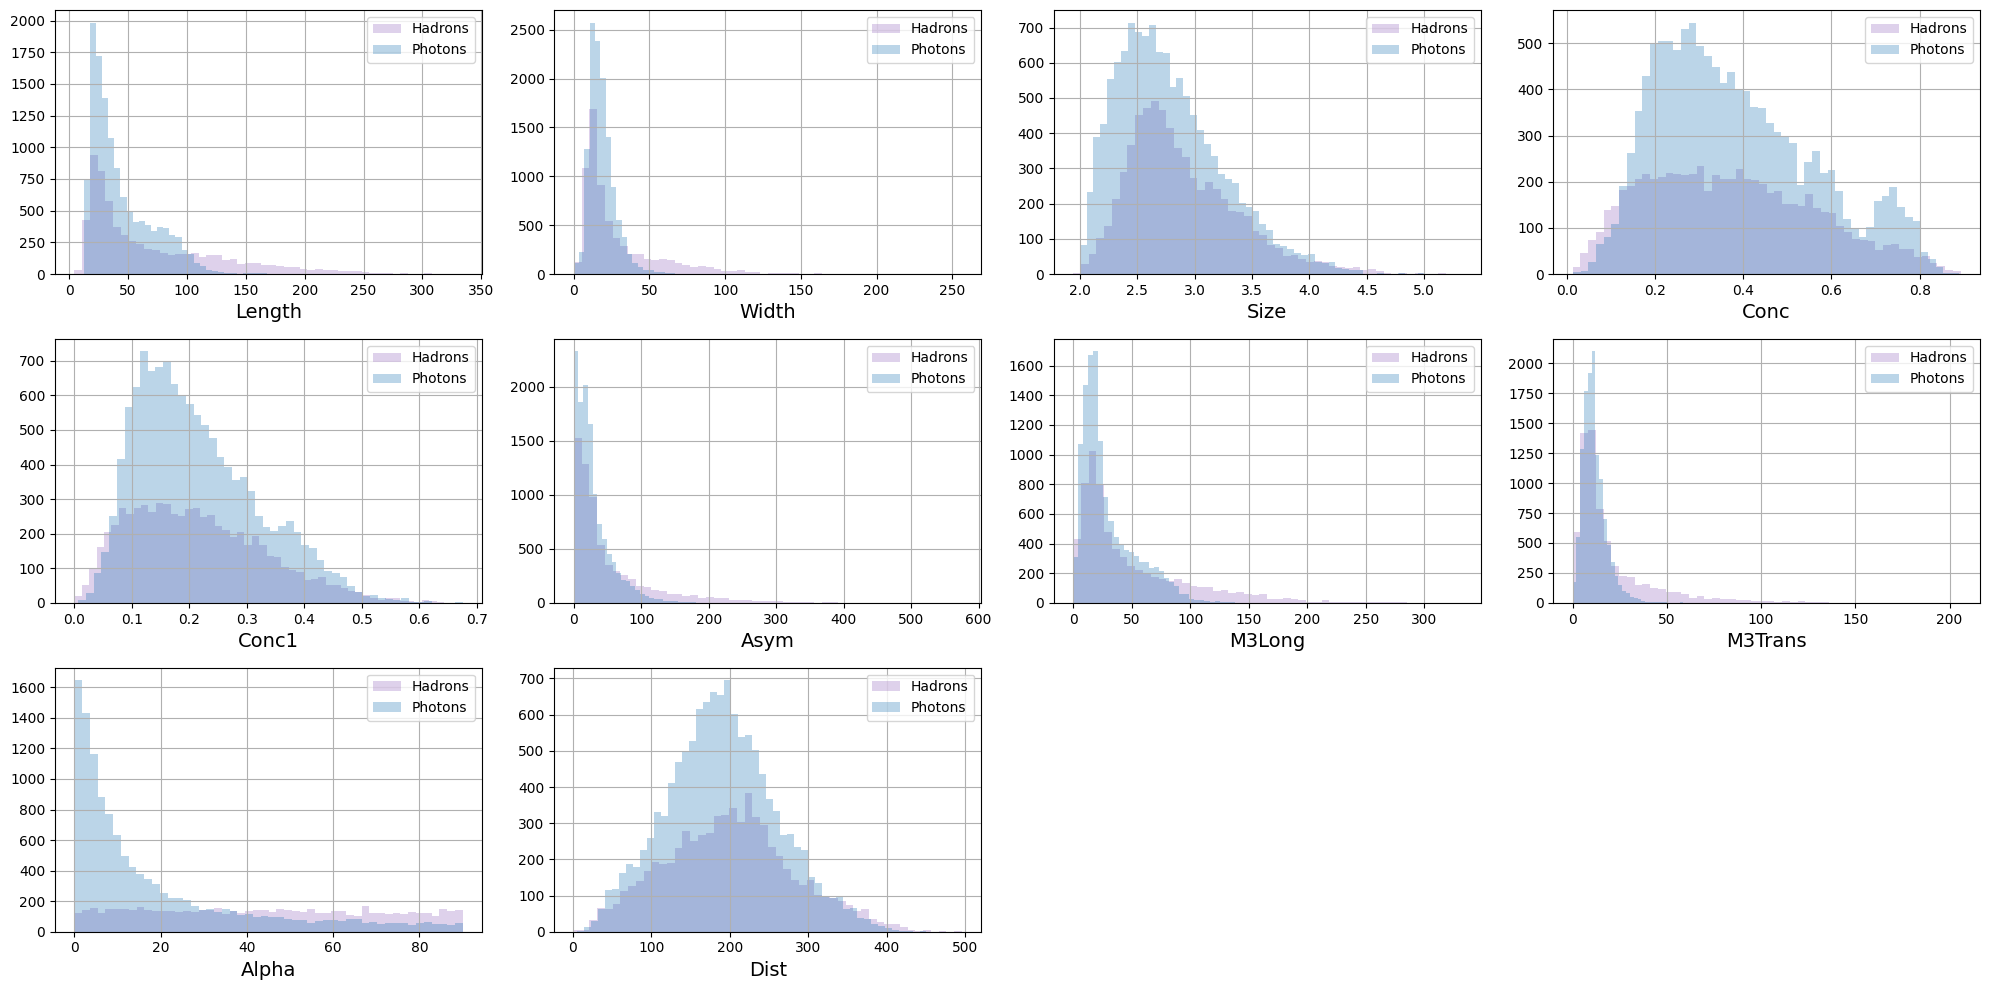

In [9]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [5]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size=0.5, shuffle = True, random_state = 11
)

## Задание 1 (0 баллов)

Проиллюстрируйте распределение y внутри train и test выборки.

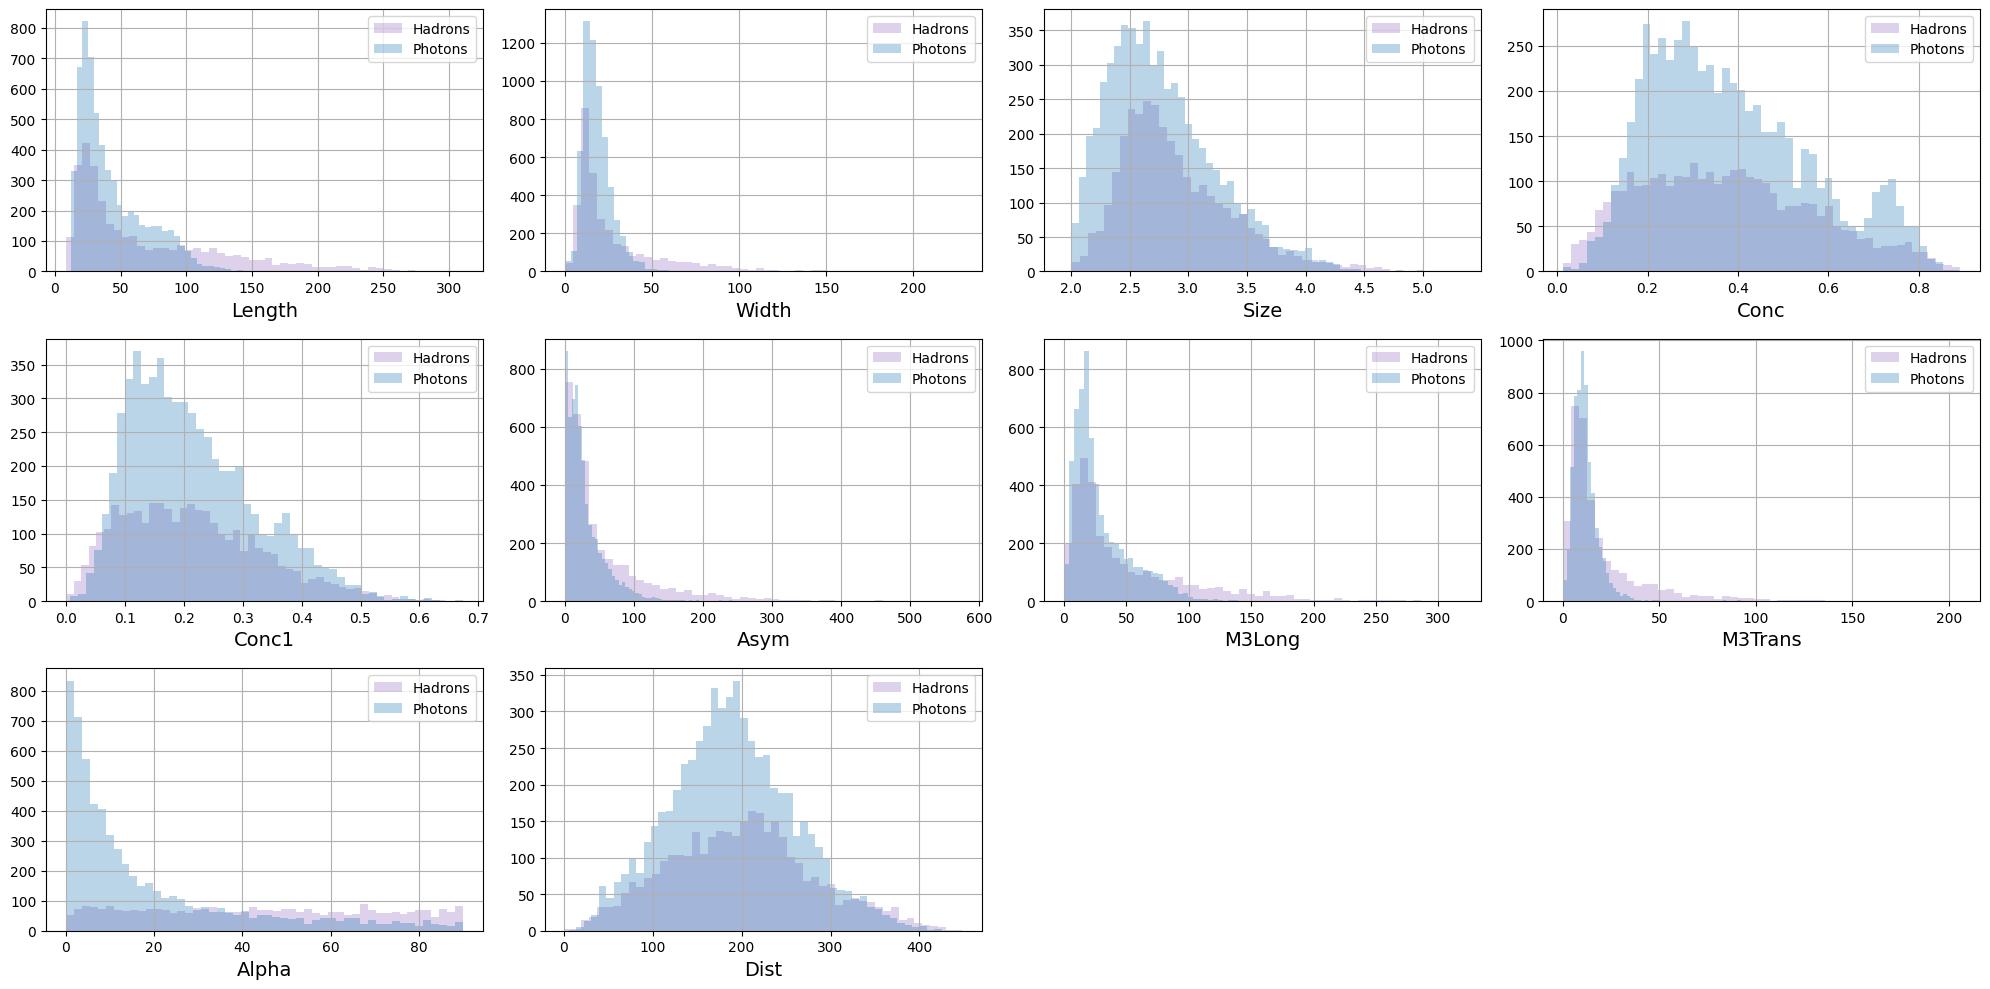

In [10]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)


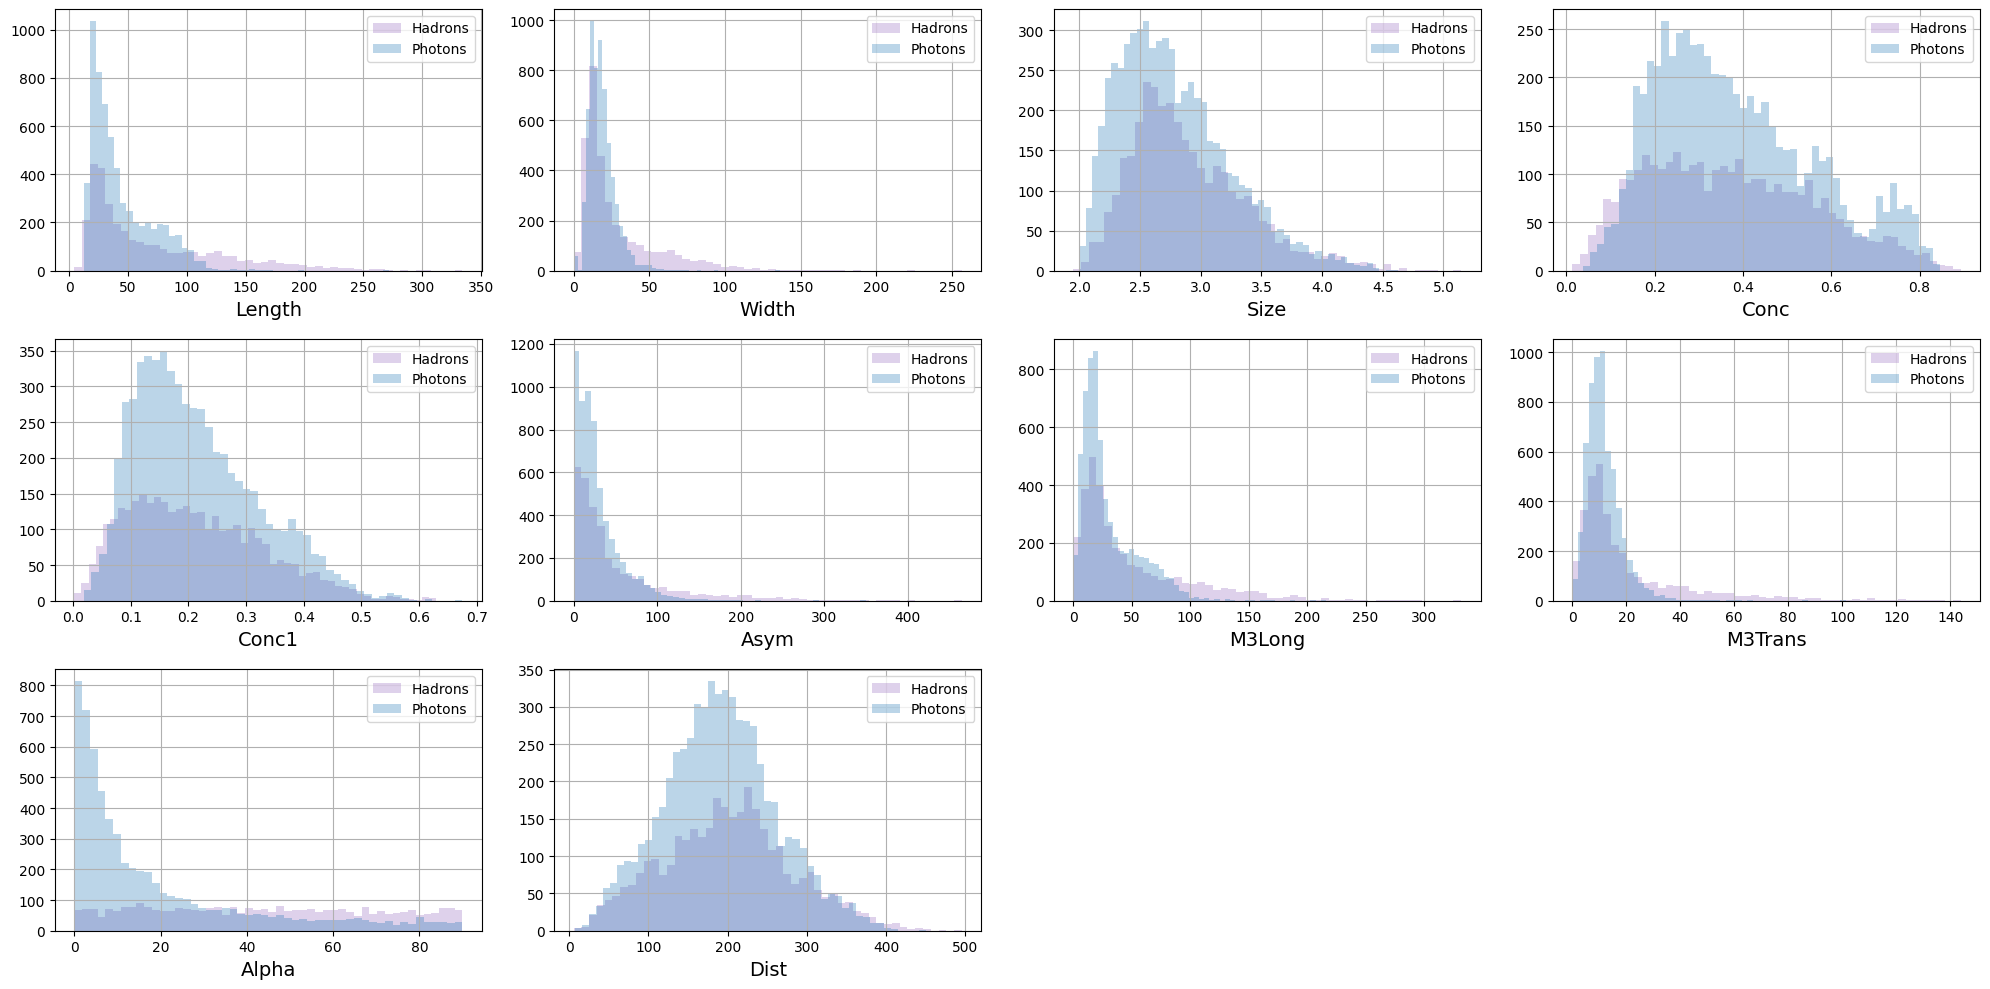

In [11]:
plot_hists(
    X_test[y_test[:, 0] == 0],
    X_test[y_test[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)


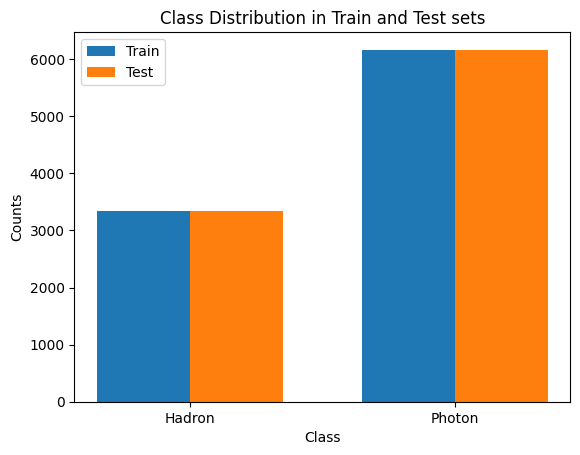

In [12]:
import matplotlib.pyplot as plt

train_counts = np.unique(y_train, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

labels = ['Hadron', 'Photon']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_counts[1], width, label='Train')
rects2 = ax.bar(x + width/2, test_counts[1], width, label='Test')

ax.set_xlabel('Class')
ax.set_ylabel('Counts')
ax.set_title('Class Distribution in Train and Test sets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


## Задание 2 (0 баллов)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
### YOUR CODE IS HERE ######
X_train = ...
X_test = ...
### THE END OF YOUR CODE ###

In [9]:
from sklearn.preprocessing import QuantileTransformer

transformer = QuantileTransformer(output_distribution='normal', random_state=0)
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

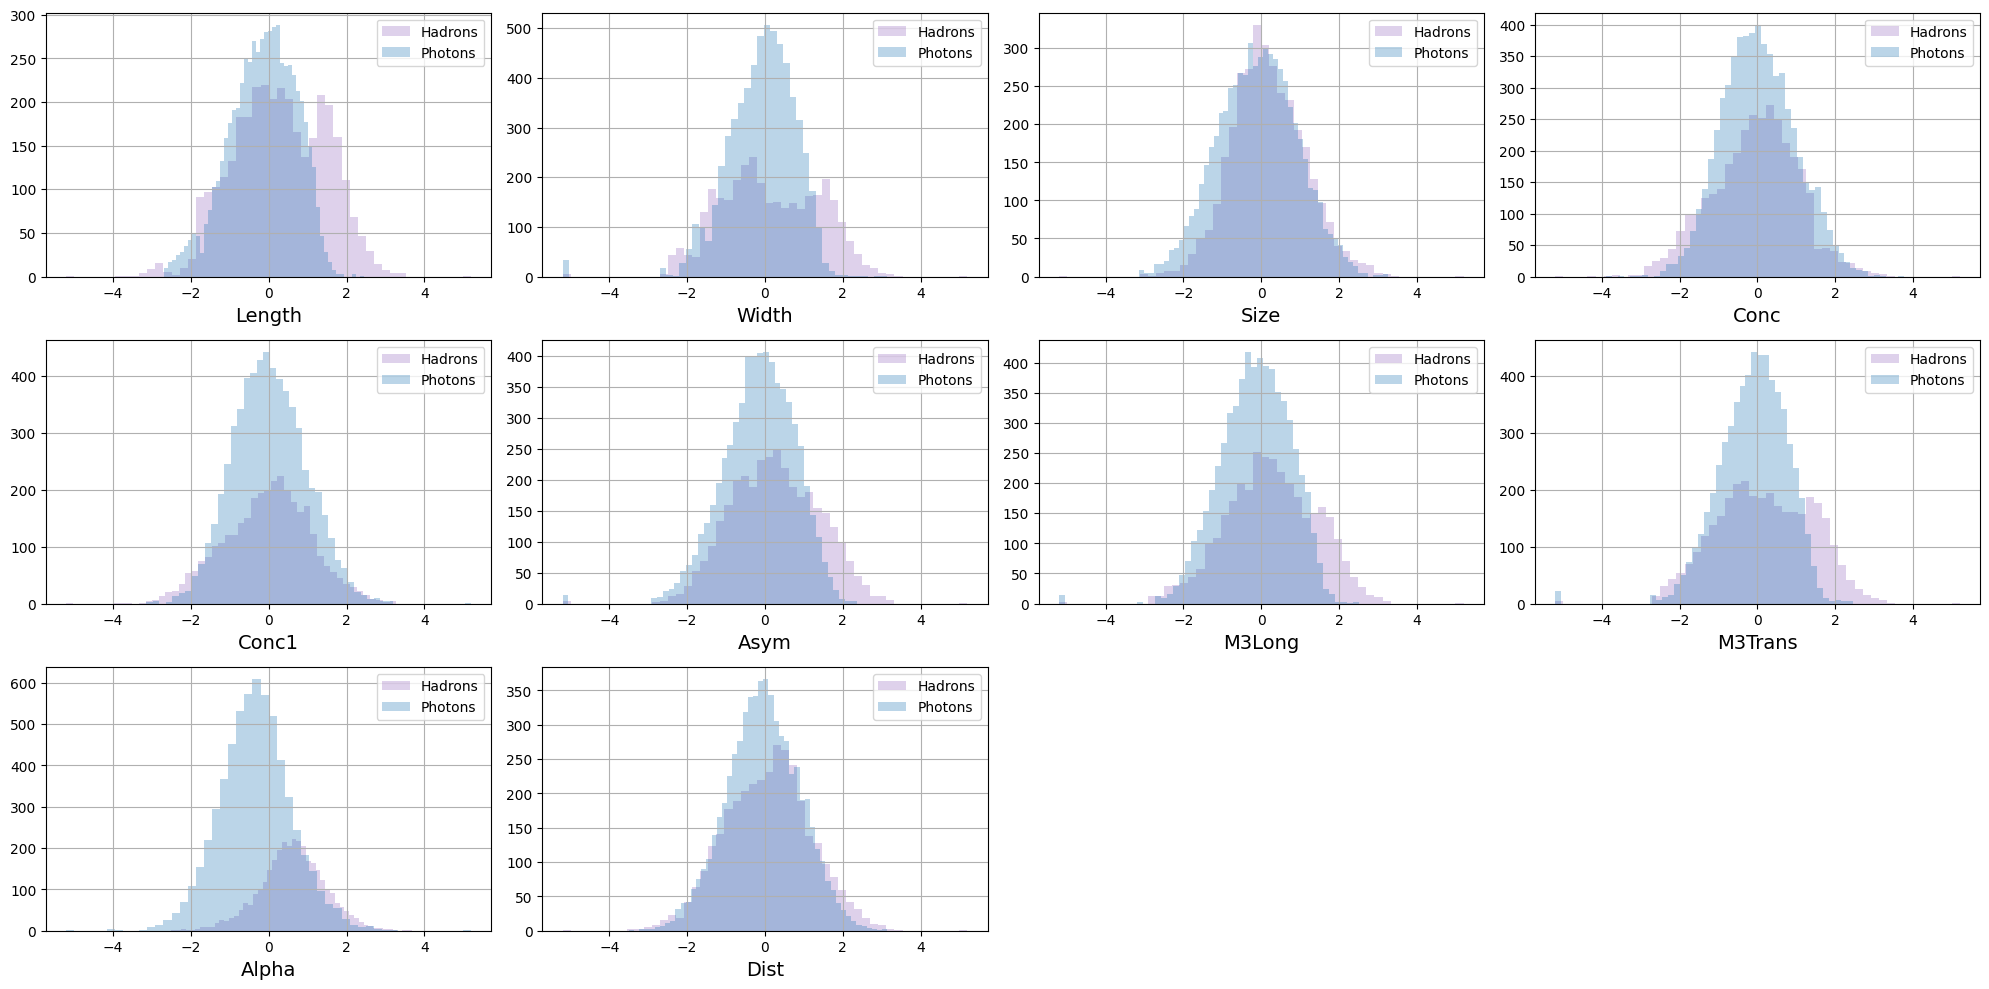

In [14]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

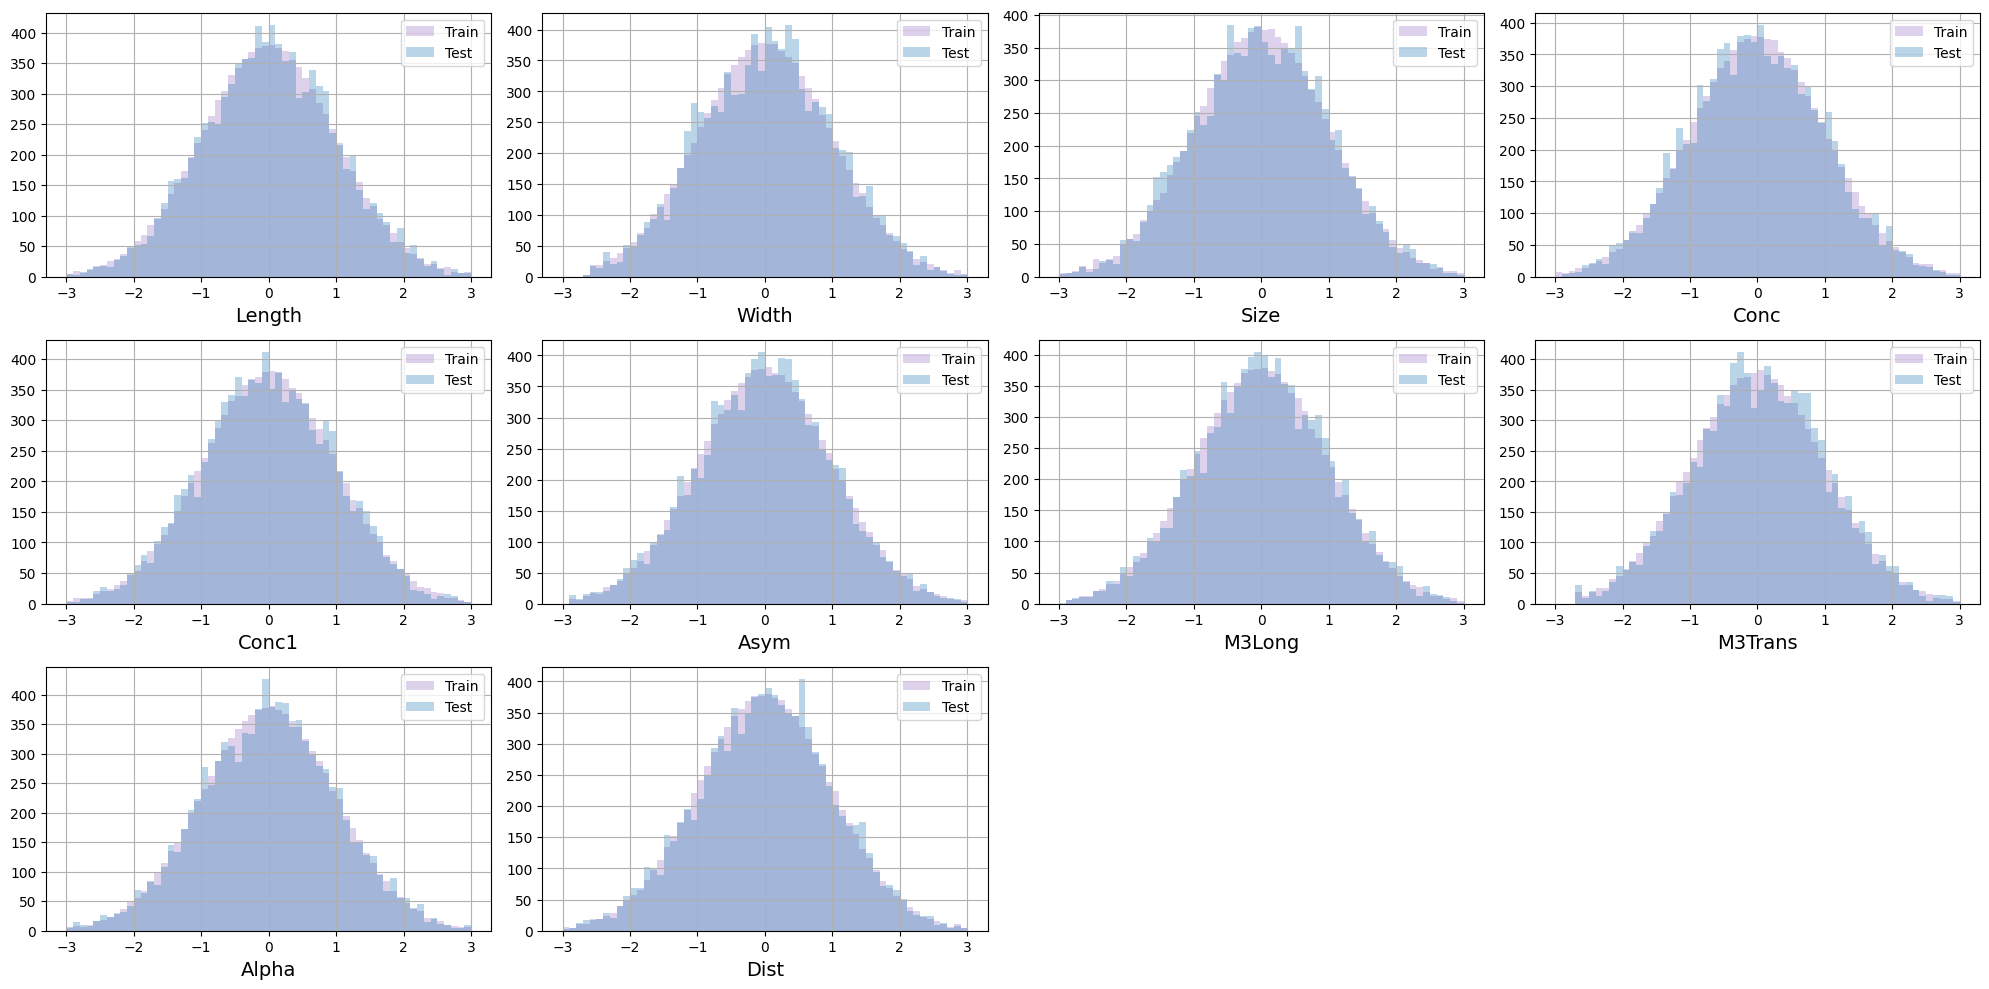

In [15]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Диффузионные модели (4 балла)

Проведем, по большому счету, такой же эксперимент, как в ДЗ-2, с диффузионной моделью.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
DEVICE

device(type='cpu')

## Задание 3 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):
   other_agent_score
    x = ...
    ### THE END OF YOUR CODE ###
    return x

In [14]:
def corrupt(x: torch.Tensor, amount: torch.Tensor) -> torch.Tensor:
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)
    return x * (1 - amount) + noise * amount


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def other_agent_score(real_data, fake_data):
    X = np.vstack([real_data, fake_data])
    y = np.hstack([np.ones(len(real_data)), np.zeros(len(fake_data))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=40)

    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, y_pred_lr)

    gb_model = GradientBoostingClassifier()
    gb_model.fit(X_train, y_train)
    y_pred_gb = gb_model.predict(X_test)
    gb_accuracy = accuracy_score(y_test, y_pred_gb)

    print(f"Logistic Regression Accuracy: {lr_accuracy}")
    print(f"Gradient Boosting Accuracy: {gb_accuracy}")
    
    return lr_accuracy, gb_accuracy


Добавим sсheduler, он пригодится вам при обучении модели.

*Советуем вниматиельно почитать доку по шедулеру.*

In [16]:
!pip install diffusers -q

In [17]:
from diffusers import DDPMScheduler

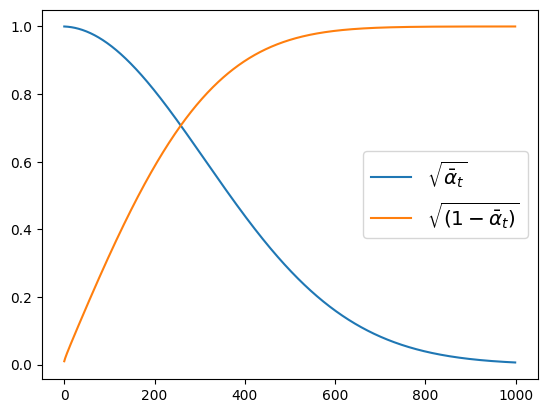

In [23]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")

## Задание 4 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######

        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return ...

In [43]:
#100 нейронов не пошло, нужно больше. 


class DiffusionGenerator(nn.Module):

    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 300)
        self.bn1 = nn.BatchNorm1d(300)
        self.fc2 = nn.Linear(300, 300)
        self.bn2 = nn.BatchNorm1d(300)
        self.fc3 = nn.Linear(300, n_outputs)

    def forward(self, z, y, t):
        t = t.unsqueeze(1)
        zyt = torch.cat((z, y, t), dim=1)
        x = F.relu(self.bn1(self.fc1(zyt)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)

        return x

## Задание 5 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [44]:
def generate_with_diffusion(model, y, latent_dim, scheduler):
    z = torch.randn(y.shape[0], latent_dim).to(DEVICE)
    y = torch.tensor(y, dtype=torch.float, device=DEVICE)
    for t in scheduler.timesteps:
        with torch.no_grad():
            t_tensor = torch.full((len(z),), t, dtype=torch.long).to(DEVICE)
            residual = model(z, y, t_tensor)
            z = scheduler.step(residual, t, z).prev_sample
    return z.cpu().numpy()

## Задание 6 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [45]:
class DiffusionFitter(object):

    def __init__(
        self,
        model,
        batch_size=64,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
    ):
        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        self.opt_gen = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.model.to(DEVICE)

    def fit(self, X, y, noise_scheduler):
        X_real = torch.tensor(X, dtype=torch.float32, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float32, device=DEVICE)
        dataset_real = TensorDataset(X_real, y_cond)
        dataloader_real = DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
        self.model.train()
        self.loss_history = []
        loss_fn = nn.MSELoss()

        for epoch in range(self.n_epochs):
            loss_epoch = 0
            count = 0
            for real_batch, cond_batch in dataloader_real:
                noise = torch.randn_like(real_batch)
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (real_batch.shape[0],)).long().to(DEVICE)
                noisy_real = noise_scheduler.add_noise(real_batch, noise, timesteps)

                pred_noise = self.model(noisy_real, cond_batch, timesteps)
                loss = loss_fn(pred_noise, noise)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()
                loss_epoch += loss.item()

                count += 1

            avg_loss = loss_epoch / count
            self.loss_history.append(avg_loss)
            print(f"Epoch {epoch + 1}/{self.n_epochs}, Loss: {avg_loss}")

            # Генерация сэмплов для оценки каждые 2 эпохи
            if (epoch + 1) % 2 == 0:
                self.model.eval()

                # Генерируем 1000 сэмплов
                X_fake = generate_with_diffusion(self.model, y_cond[:1000], self.latent_dim, noise_scheduler)
                X_real_sample = X_real[:1000].cpu().numpy()

                # Вызываем функцию оценки other_agent_score
                lr_accuracy, gb_accuracy = other_agent_score(X_real_sample, X_fake)

                print(f"Epoch {epoch + 1}/{self.n_epochs}, Loss: {avg_loss:.4f}, LR Accuracy: {lr_accuracy:.4f}, GB Accuracy: {gb_accuracy:.4f}")

                self.model.train()

        self.model.eval()

In [46]:
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y_train.shape[1] + 1, n_outputs=X_train.shape[1])

diffusion_fitter = DiffusionFitter(
    model=model,
    batch_size=64,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample=False)
diffusion_fitter.fit(X_train, y_train, noise_scheduler)


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1/100, Loss: 0.7987361162300878
Epoch 2/100, Loss: 0.4686494871673968


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.922
Gradient Boosting Accuracy: 0.972
Epoch 2/100, Loss: 0.4686, LR Accuracy: 0.9220, GB Accuracy: 0.9720


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 3/100, Loss: 0.3463159762572922
Epoch 4/100, Loss: 0.3155176902577381


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.694
Gradient Boosting Accuracy: 0.854
Epoch 4/100, Loss: 0.3155, LR Accuracy: 0.6940, GB Accuracy: 0.8540


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 5/100, Loss: 0.2919499904117328
Epoch 6/100, Loss: 0.2809997852016615


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.69
Gradient Boosting Accuracy: 0.758
Epoch 6/100, Loss: 0.2810, LR Accuracy: 0.6900, GB Accuracy: 0.7580


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 7/100, Loss: 0.2804143287791502
Epoch 8/100, Loss: 0.27184685444671836


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.584
Gradient Boosting Accuracy: 0.664
Epoch 8/100, Loss: 0.2718, LR Accuracy: 0.5840, GB Accuracy: 0.6640


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 9/100, Loss: 0.26522841169530115
Epoch 10/100, Loss: 0.26227119775026436


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.588
Gradient Boosting Accuracy: 0.672
Epoch 10/100, Loss: 0.2623, LR Accuracy: 0.5880, GB Accuracy: 0.6720


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 11/100, Loss: 0.26067642147509046
Epoch 12/100, Loss: 0.2549849829617763


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.598
Gradient Boosting Accuracy: 0.674
Epoch 12/100, Loss: 0.2550, LR Accuracy: 0.5980, GB Accuracy: 0.6740


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 13/100, Loss: 0.25383603332826754
Epoch 14/100, Loss: 0.24936779823479235


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.652
Gradient Boosting Accuracy: 0.694
Epoch 14/100, Loss: 0.2494, LR Accuracy: 0.6520, GB Accuracy: 0.6940


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 15/100, Loss: 0.250470680578443
Epoch 16/100, Loss: 0.24562074704058218


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.654
Gradient Boosting Accuracy: 0.672
Epoch 16/100, Loss: 0.2456, LR Accuracy: 0.6540, GB Accuracy: 0.6720


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 17/100, Loss: 0.2477994422184541
Epoch 18/100, Loss: 0.24530764664179527


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.7
Gradient Boosting Accuracy: 0.718
Epoch 18/100, Loss: 0.2453, LR Accuracy: 0.7000, GB Accuracy: 0.7180


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 19/100, Loss: 0.24891192341010843
Epoch 20/100, Loss: 0.24680851079873592


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.644
Gradient Boosting Accuracy: 0.658
Epoch 20/100, Loss: 0.2468, LR Accuracy: 0.6440, GB Accuracy: 0.6580


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 21/100, Loss: 0.24492534925073586
Epoch 22/100, Loss: 0.23908851270707662


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.554
Gradient Boosting Accuracy: 0.602
Epoch 22/100, Loss: 0.2391, LR Accuracy: 0.5540, GB Accuracy: 0.6020


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 23/100, Loss: 0.24376734471161093
Epoch 24/100, Loss: 0.2421864145154121


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.604
Gradient Boosting Accuracy: 0.64
Epoch 24/100, Loss: 0.2422, LR Accuracy: 0.6040, GB Accuracy: 0.6400


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 25/100, Loss: 0.23849162269358667
Epoch 26/100, Loss: 0.23611276431771733


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.636
Gradient Boosting Accuracy: 0.664
Epoch 26/100, Loss: 0.2361, LR Accuracy: 0.6360, GB Accuracy: 0.6640


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 27/100, Loss: 0.24348583517458616
Epoch 28/100, Loss: 0.24315563604335658


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.602
Gradient Boosting Accuracy: 0.648
Epoch 28/100, Loss: 0.2432, LR Accuracy: 0.6020, GB Accuracy: 0.6480


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 29/100, Loss: 0.24241275895361933
Epoch 30/100, Loss: 0.24071613434177117


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.518
Gradient Boosting Accuracy: 0.59
Epoch 30/100, Loss: 0.2407, LR Accuracy: 0.5180, GB Accuracy: 0.5900


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 31/100, Loss: 0.24192277557097824
Epoch 32/100, Loss: 0.23909145973672802


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.598
Gradient Boosting Accuracy: 0.66
Epoch 32/100, Loss: 0.2391, LR Accuracy: 0.5980, GB Accuracy: 0.6600


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 33/100, Loss: 0.24264642856265076
Epoch 34/100, Loss: 0.24249897957248176


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.612
Gradient Boosting Accuracy: 0.608
Epoch 34/100, Loss: 0.2425, LR Accuracy: 0.6120, GB Accuracy: 0.6080


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 35/100, Loss: 0.24284096282200526
Epoch 36/100, Loss: 0.23835979222051248


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.64
Gradient Boosting Accuracy: 0.626
Epoch 36/100, Loss: 0.2384, LR Accuracy: 0.6400, GB Accuracy: 0.6260


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 37/100, Loss: 0.2405552332033247
Epoch 38/100, Loss: 0.23396302239606845


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.65
Gradient Boosting Accuracy: 0.674
Epoch 38/100, Loss: 0.2340, LR Accuracy: 0.6500, GB Accuracy: 0.6740


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 39/100, Loss: 0.23379098618990624
Epoch 40/100, Loss: 0.2362482202733123


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.572
Gradient Boosting Accuracy: 0.606
Epoch 40/100, Loss: 0.2362, LR Accuracy: 0.5720, GB Accuracy: 0.6060


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 41/100, Loss: 0.23667539866178627
Epoch 42/100, Loss: 0.2329611072204257


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.634
Gradient Boosting Accuracy: 0.632
Epoch 42/100, Loss: 0.2330, LR Accuracy: 0.6340, GB Accuracy: 0.6320


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 43/100, Loss: 0.23706629682307276
Epoch 44/100, Loss: 0.23682853339502474


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.63
Gradient Boosting Accuracy: 0.65
Epoch 44/100, Loss: 0.2368, LR Accuracy: 0.6300, GB Accuracy: 0.6500


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 45/100, Loss: 0.23993414570421182
Epoch 46/100, Loss: 0.24072387604505424


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.678
Gradient Boosting Accuracy: 0.628
Epoch 46/100, Loss: 0.2407, LR Accuracy: 0.6780, GB Accuracy: 0.6280


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 47/100, Loss: 0.23776437882208984
Epoch 48/100, Loss: 0.23756631198745445


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.642
Gradient Boosting Accuracy: 0.678
Epoch 48/100, Loss: 0.2376, LR Accuracy: 0.6420, GB Accuracy: 0.6780


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 49/100, Loss: 0.2356592129740939
Epoch 50/100, Loss: 0.2402073362929709


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.634
Gradient Boosting Accuracy: 0.62
Epoch 50/100, Loss: 0.2402, LR Accuracy: 0.6340, GB Accuracy: 0.6200


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 51/100, Loss: 0.23992858672102027
Epoch 52/100, Loss: 0.23391753095108392


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.61
Gradient Boosting Accuracy: 0.638
Epoch 52/100, Loss: 0.2339, LR Accuracy: 0.6100, GB Accuracy: 0.6380


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 53/100, Loss: 0.23723699297480935
Epoch 54/100, Loss: 0.231392654196528


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.53
Gradient Boosting Accuracy: 0.544
Epoch 54/100, Loss: 0.2314, LR Accuracy: 0.5300, GB Accuracy: 0.5440


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 55/100, Loss: 0.23224710508080937
Epoch 56/100, Loss: 0.2357125899335682


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.604
Gradient Boosting Accuracy: 0.624
Epoch 56/100, Loss: 0.2357, LR Accuracy: 0.6040, GB Accuracy: 0.6240


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 57/100, Loss: 0.23736173694565793
Epoch 58/100, Loss: 0.2353347778920359


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.634
Gradient Boosting Accuracy: 0.646
Epoch 58/100, Loss: 0.2353, LR Accuracy: 0.6340, GB Accuracy: 0.6460


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 59/100, Loss: 0.23362164179350706
Epoch 60/100, Loss: 0.23103072099237634


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.574
Gradient Boosting Accuracy: 0.614
Epoch 60/100, Loss: 0.2310, LR Accuracy: 0.5740, GB Accuracy: 0.6140


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 61/100, Loss: 0.23129723166059327
Epoch 62/100, Loss: 0.22670553534622961


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.54
Gradient Boosting Accuracy: 0.616
Epoch 62/100, Loss: 0.2267, LR Accuracy: 0.5400, GB Accuracy: 0.6160


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 63/100, Loss: 0.23369950866139175
Epoch 64/100, Loss: 0.23378065008445073


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.576
Gradient Boosting Accuracy: 0.594
Epoch 64/100, Loss: 0.2338, LR Accuracy: 0.5760, GB Accuracy: 0.5940


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 65/100, Loss: 0.23214414035713912
Epoch 66/100, Loss: 0.2308734358357103


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.574
Gradient Boosting Accuracy: 0.588
Epoch 66/100, Loss: 0.2309, LR Accuracy: 0.5740, GB Accuracy: 0.5880


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 67/100, Loss: 0.2283333830985447
Epoch 68/100, Loss: 0.22620921016939535


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.6
Gradient Boosting Accuracy: 0.614
Epoch 68/100, Loss: 0.2262, LR Accuracy: 0.6000, GB Accuracy: 0.6140


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 69/100, Loss: 0.22553380223728667
Epoch 70/100, Loss: 0.23309345093349482


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.586
Gradient Boosting Accuracy: 0.556
Epoch 70/100, Loss: 0.2331, LR Accuracy: 0.5860, GB Accuracy: 0.5560


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 71/100, Loss: 0.23365928712707237
Epoch 72/100, Loss: 0.22963175037563247


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.586
Gradient Boosting Accuracy: 0.618
Epoch 72/100, Loss: 0.2296, LR Accuracy: 0.5860, GB Accuracy: 0.6180


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 73/100, Loss: 0.23180081350291334
Epoch 74/100, Loss: 0.2291460709283816


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.632
Gradient Boosting Accuracy: 0.564
Epoch 74/100, Loss: 0.2291, LR Accuracy: 0.6320, GB Accuracy: 0.5640


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 75/100, Loss: 0.23388434946537018
Epoch 76/100, Loss: 0.23584495704846095


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.524
Gradient Boosting Accuracy: 0.572
Epoch 76/100, Loss: 0.2358, LR Accuracy: 0.5240, GB Accuracy: 0.5720


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 77/100, Loss: 0.23481034082454322
Epoch 78/100, Loss: 0.2290438963662858


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.634
Gradient Boosting Accuracy: 0.6
Epoch 78/100, Loss: 0.2290, LR Accuracy: 0.6340, GB Accuracy: 0.6000


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 79/100, Loss: 0.22493373697636113
Epoch 80/100, Loss: 0.22768310472469203


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.576
Gradient Boosting Accuracy: 0.622
Epoch 80/100, Loss: 0.2277, LR Accuracy: 0.5760, GB Accuracy: 0.6220


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 81/100, Loss: 0.22784088291977875
Epoch 82/100, Loss: 0.2340661424318416


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.612
Gradient Boosting Accuracy: 0.602
Epoch 82/100, Loss: 0.2341, LR Accuracy: 0.6120, GB Accuracy: 0.6020


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 83/100, Loss: 0.22932442912719395
Epoch 84/100, Loss: 0.23220172854477927


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.584
Gradient Boosting Accuracy: 0.594
Epoch 84/100, Loss: 0.2322, LR Accuracy: 0.5840, GB Accuracy: 0.5940


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 85/100, Loss: 0.23365727477025666
Epoch 86/100, Loss: 0.22951059693458095


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.574
Gradient Boosting Accuracy: 0.614
Epoch 86/100, Loss: 0.2295, LR Accuracy: 0.5740, GB Accuracy: 0.6140


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 87/100, Loss: 0.2346497368092505
Epoch 88/100, Loss: 0.23352239720973392


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.596
Gradient Boosting Accuracy: 0.594
Epoch 88/100, Loss: 0.2335, LR Accuracy: 0.5960, GB Accuracy: 0.5940


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 89/100, Loss: 0.22933506820625907
Epoch 90/100, Loss: 0.23111029539332295


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.612
Gradient Boosting Accuracy: 0.606
Epoch 90/100, Loss: 0.2311, LR Accuracy: 0.6120, GB Accuracy: 0.6060


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 91/100, Loss: 0.23559104191176844
Epoch 92/100, Loss: 0.22877384732233597


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.63
Gradient Boosting Accuracy: 0.668
Epoch 92/100, Loss: 0.2288, LR Accuracy: 0.6300, GB Accuracy: 0.6680


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 93/100, Loss: 0.23163412341335476
Epoch 94/100, Loss: 0.22931883209103707


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.544
Gradient Boosting Accuracy: 0.612
Epoch 94/100, Loss: 0.2293, LR Accuracy: 0.5440, GB Accuracy: 0.6120


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 95/100, Loss: 0.2293206621336457
Epoch 96/100, Loss: 0.228173489138584


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.608
Gradient Boosting Accuracy: 0.614
Epoch 96/100, Loss: 0.2282, LR Accuracy: 0.6080, GB Accuracy: 0.6140


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 97/100, Loss: 0.23057600145772
Epoch 98/100, Loss: 0.23036327828096864


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.56
Gradient Boosting Accuracy: 0.576
Epoch 98/100, Loss: 0.2304, LR Accuracy: 0.5600, GB Accuracy: 0.5760


/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 99/100, Loss: 0.22672867544945455
Epoch 100/100, Loss: 0.22927479285921826


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


Logistic Regression Accuracy: 0.556
Gradient Boosting Accuracy: 0.574
Epoch 100/100, Loss: 0.2293, LR Accuracy: 0.5560, GB Accuracy: 0.5740


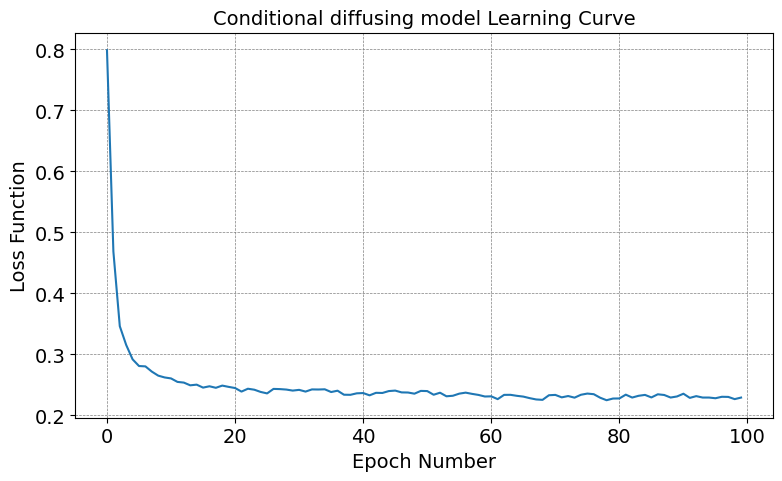

In [47]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusion_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(visible=True, linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 7 (0.5 балла)
По аналогии с прошлым экспериментом (из ДЗ-2) с GAN моделью сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с сWGAN моделью?

In [48]:
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=DEVICE)

X_fake_train = generate_with_diffusion(diffusion_fitter.model, y_train_tensor, latent_dim, noise_scheduler)
X_fake_test = generate_with_diffusion(diffusion_fitter.model, y_test_tensor, latent_dim, noise_scheduler)

XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))


/tmp/ipykernel_31/1751672450.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float, device=DEVICE)


In [49]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [50]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.7244988782630714


Результаты получились средние. ROC-AUC: 0.72, что далеко от идеала - 0,5. Есть куда рости. В приниципе такой же результат дал GAN, там качество было около 0.7. Ниже распределения для настоящих и фейковых значений. В принципе похоже.

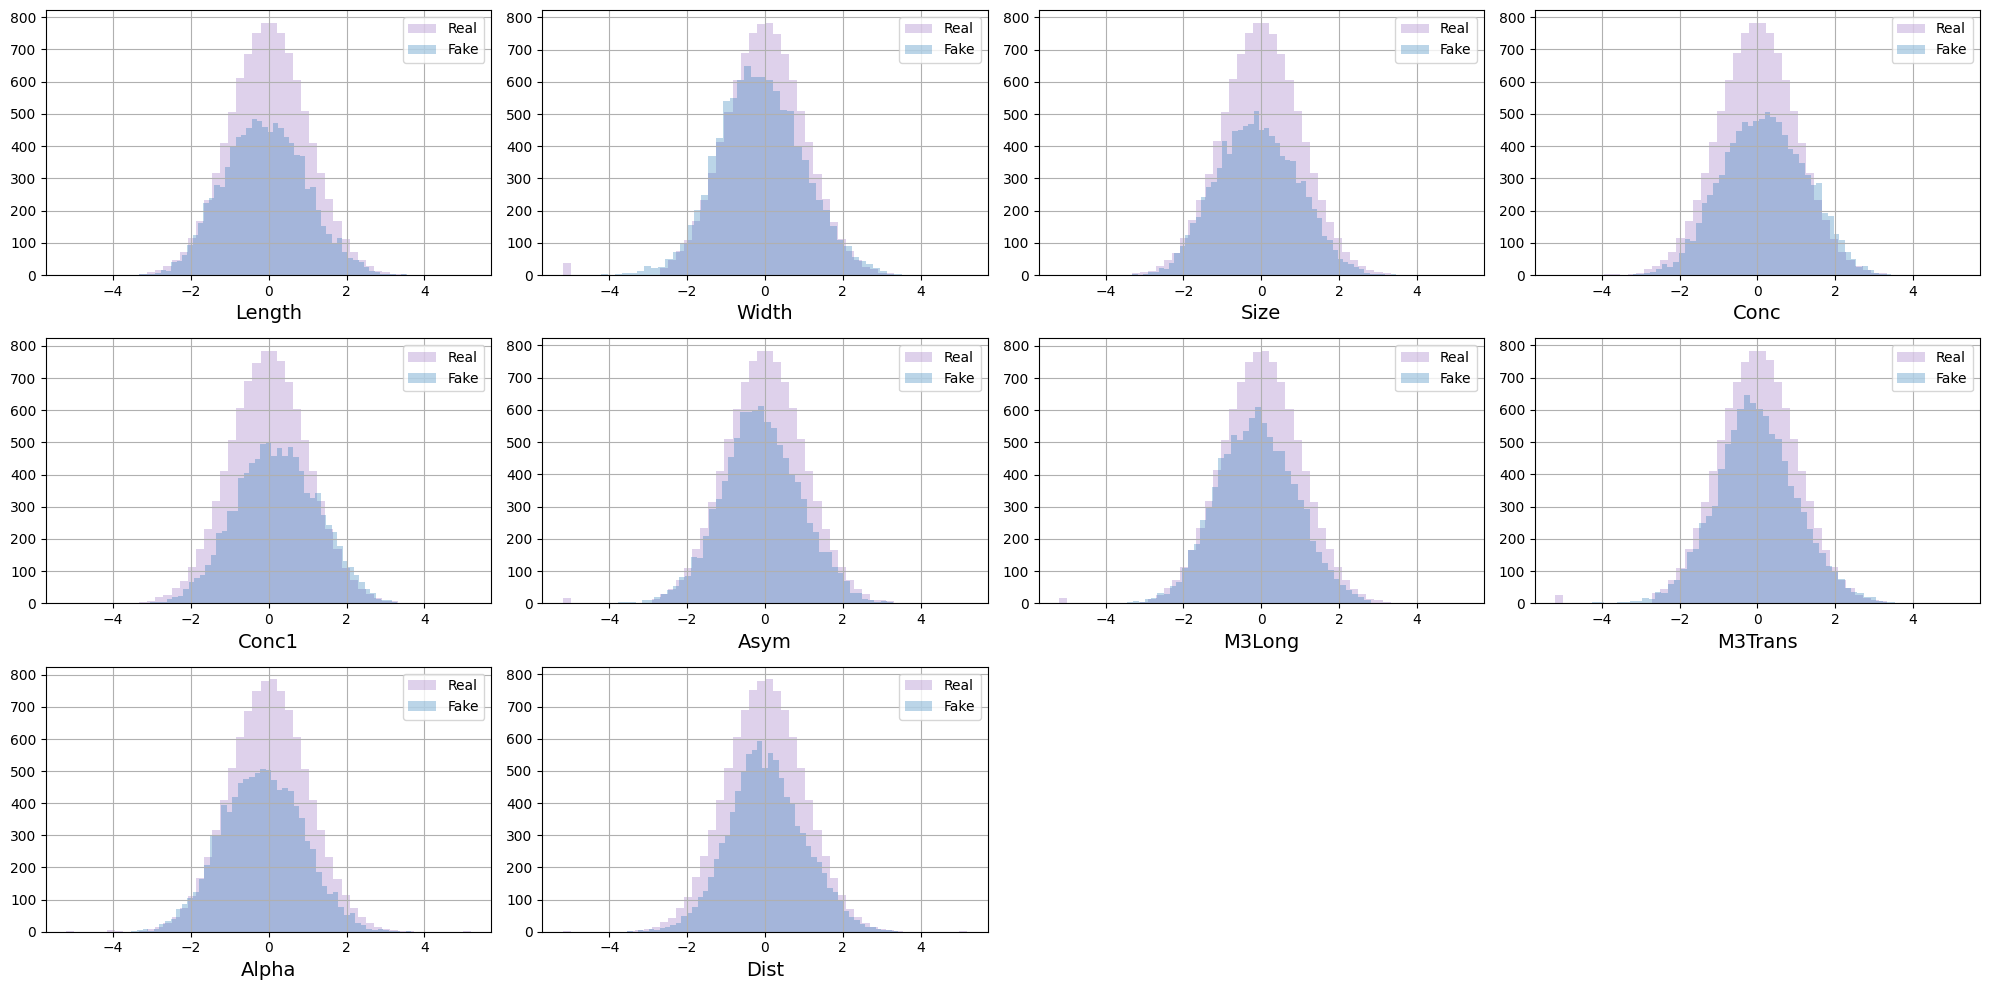

In [51]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

# Потоки (4 балла)

## Задание 8 (1.5 балла)

Диффузия показала себя как достойный конкурент GAN модели. Так как данных не много, обучали не долго, задача не сложная - отличия от GAN не так заметны, но все равно достойные.

Для Diffusion получили ROC AUC около 0.73 (меньше лучше). Попробуем обучить RealNVP для решения этой задачи.

**Дополните базовый класс для нормализационного необходимым.**

<center><img src="img/mem1.jpg" width="500"></center>

<center><img src="img/mem2.jpg" width="500"></center>

In [ ]:
# Main class for NormFlow
class NormalizingFlow(nn.Module):

    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()

        # your code below

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, change = layer.f(x)
            if log_likelihood is not None:
                log_likelihood = # your code here
            else:
                log_likelihood = # your code here

        log_likelihood = # your code here

        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples, ))

        for layer in self.layers[::-1]:
            x = layer.g(x)

        return x

In [10]:
class NormalizingFlow(nn.Module):
    def __init__(self, layers, prior):
        super(NormalizingFlow, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.prior = prior

    def log_prob(self, x):
        log_likelihood = None

        for layer in self.layers:
            x, log_det = layer.f(x)
            if log_likelihood is None:
                log_likelihood = log_det
            else:
                log_likelihood += log_det

        log_likelihood += self.prior.log_prob(x)
        return log_likelihood.mean()

    def sample(self, num_samples):
        x = self.prior.sample((num_samples,))
        for layer in self.layers[::-1]:
            x = layer.g(x)
        return x


## Задание 9 (2 балла)

Реализуйте нейронную сеть RealNVP. Возьмите для прямого и обратного преобразования нейронную сеть (функцию) со следующими параметрами:

- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

In [11]:
class RealNVP(nn.Module):
    def __init__(self, var_size, mask, hidden=100):
        super(RealNVP, self).__init__()
        self.mask = mask  # Маска для чередования переменных
        self.var_size = var_size

        # Нейронные сети для параметров t и s. Я предворительно скрыл слои, чтобы попробовать сделать модель еще лучше потом
        self.nn_t = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            # nn.Linear(hidden, hidden),
            # nn.ReLU(),
            nn.Linear(hidden, var_size)
        )

        self.nn_s = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            # nn.Linear(hidden, hidden),
            # nn.ReLU(),
            nn.Linear(hidden, var_size)
        )

    # Прямое преобразование
    def f(self, x):
        mask = self.mask.to(x.device)
        t = self.nn_t(x * mask)  # Вычисление t(x)
        s = self.nn_s(x * mask)  # Вычисление s(x)
        new_x = mask * x + (1 - mask) * (x * torch.exp(s) + t)  # Преобразование x
        log_det = ((1 - mask) * s).sum(dim=1)  # Логарифм детерминанта

        return new_x, log_det

    # Обратное преобразование
    def g(self, x):
        mask = self.mask.to(x.device)
        t = self.nn_t(x * mask)
        s = self.nn_s(x * mask)
        new_x = mask * x + (1 - mask) * (x - t) * torch.exp(-s)
        return new_x


In [12]:
def train_nf(trainloader, nf, opt, num_epochs):
    nf.train() 
    loss_trace = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}')
        for batch in trainloader:
            x = batch.float().to(DEVICE)

            opt.zero_grad()
            loss = -nf.log_prob(x)
            loss.backward()
            opt.step()

            loss_trace.append(loss.item())

        print(f"Loss at epoch {epoch + 1}: {loss_trace[-1]:.4f}")

In [13]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10).to(DEVICE), torch.eye(10).to(DEVICE))

layers = []
for i in range(4):
    mask = ((torch.arange(10) + i) % 2).float().to(DEVICE)
    layers.append(RealNVP(var_size=10, mask=mask))

nf = NormalizingFlow(layers=layers, prior=prior)
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)
trainloader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)


train_nf(trainloader, nf, opt, num_epochs=100)

Epoch 1
Loss at epoch 1: 9.4457
Epoch 2
Loss at epoch 2: 8.0378
Epoch 3
Loss at epoch 3: 8.5665
Epoch 4
Loss at epoch 4: 8.7049
Epoch 5
Loss at epoch 5: 7.3120
Epoch 6
Loss at epoch 6: 8.3932
Epoch 7
Loss at epoch 7: 7.3979
Epoch 8
Loss at epoch 8: 8.9028
Epoch 9
Loss at epoch 9: 7.4664
Epoch 10
Loss at epoch 10: 6.8484
Epoch 11
Loss at epoch 11: 7.1119
Epoch 12
Loss at epoch 12: 7.9851
Epoch 13
Loss at epoch 13: 7.8310
Epoch 14
Loss at epoch 14: 7.1301
Epoch 15
Loss at epoch 15: 6.8360
Epoch 16
Loss at epoch 16: 7.1648
Epoch 17
Loss at epoch 17: 7.0383
Epoch 18
Loss at epoch 18: 6.4338
Epoch 19
Loss at epoch 19: 7.4825
Epoch 20
Loss at epoch 20: 6.8118
Epoch 21
Loss at epoch 21: 8.2281
Epoch 22
Loss at epoch 22: 7.2341
Epoch 23
Loss at epoch 23: 5.9435
Epoch 24
Loss at epoch 24: 6.5890
Epoch 25
Loss at epoch 25: 7.5884
Epoch 26
Loss at epoch 26: 7.3927
Epoch 27
Loss at epoch 27: 6.3392
Epoch 28
Loss at epoch 28: 6.1699
Epoch 29
Loss at epoch 29: 7.5949
Epoch 30
Loss at epoch 30: 6.936

## Задание 10 (0.5 балла)

По аналогии с прошлым экспериментом с диффузией сгенерируйте выборку фейковых объектов, равную размеру тестовой выборки, и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с остальными моделями?

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

num_samples_train = len(X_train)  
num_samples_test = len(X_test)


X_fake_train = nf.sample(num_samples_train)
X_fake_test = nf.sample(num_samples_test)    

XX_train = np.concatenate((X_fake_train.detach().numpy(), X_train), axis=0)
XX_test = np.concatenate((X_fake_test.detach().numpy(), X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))  
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))     

clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

yy_test_proba = clf.predict_proba(XX_test)[:, 1]
auc = roc_auc_score(yy_test, yy_test_proba)

print("ROC AUC = ", auc)


ROC AUC =  0.6200855262212226


Результаты получилось намного лучше того, что было в других моделях. При том, что есть возможности куда рости дальше улучшая модель. 

# Улучшения (1+ балл)

Попробуйте настроить параметры обучения какой-нибудь модели или еще как-нибудь их улучшить, чтобы получить как можно меньший ROC AUC. Что получилось? Какая модель лучше?

Ставим 0.1 балл за каждую сотую скора сверх (сниз) ROC-AUC=0.65 невключительно. Т.е. за 0.65 получаете 0, за 0.649 -- 0.1, 0.639 -- 0.2, 0.609 -- 0.5, 0.559 -- 1

In [20]:
class RealNVP(nn.Module):
    def __init__(self, var_size, mask, hidden=256):
        super(RealNVP, self).__init__()
        self.mask = mask
        self.var_size = var_size

        self.nn_t = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size)
        )

        self.nn_s = nn.Sequential(
            nn.Linear(var_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, var_size)
        )

    def f(self, x):
        mask = self.mask.to(x.device)
        t = self.nn_t(x * mask)
        s = self.nn_s(x * mask)
        new_x = mask * x + (1 - mask) * (x * torch.exp(s) + t)
        log_det = ((1 - mask) * s).sum(dim=1)

        return new_x, log_det

    def g(self, x):
        mask = self.mask.to(x.device)
        t = self.nn_t(x * mask)
        s = self.nn_s(x * mask)
        new_x = mask * x + (1 - mask) * (x - t) * torch.exp(-s)
        return new_x



In [22]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10).to(DEVICE), torch.eye(10).to(DEVICE))

layers = []
for i in range(4):
    mask = ((torch.arange(10) + i) % 2).float().to(DEVICE)
    layers.append(RealNVP(var_size=10, mask=mask))

nf = NormalizingFlow(layers=layers, prior=prior)
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)
trainloader = torch.utils.data.DataLoader(X_train, batch_size=64, shuffle=True)


train_nf(trainloader, nf, opt, num_epochs=100)

Epoch 1
Loss at epoch 1: 7.8886
Epoch 2
Loss at epoch 2: 7.4360
Epoch 3
Loss at epoch 3: 6.8707
Epoch 4
Loss at epoch 4: 7.4245
Epoch 5
Loss at epoch 5: 8.1461
Epoch 6
Loss at epoch 6: 6.8008
Epoch 7
Loss at epoch 7: 7.6501
Epoch 8
Loss at epoch 8: 7.2775
Epoch 9
Loss at epoch 9: 7.2337
Epoch 10
Loss at epoch 10: 6.3592
Epoch 11
Loss at epoch 11: 7.0549
Epoch 12
Loss at epoch 12: 7.3769
Epoch 13
Loss at epoch 13: 7.4398
Epoch 14
Loss at epoch 14: 6.7760
Epoch 15
Loss at epoch 15: 7.3224
Epoch 16
Loss at epoch 16: 6.7359
Epoch 17
Loss at epoch 17: 7.2858
Epoch 18
Loss at epoch 18: 5.6948
Epoch 19
Loss at epoch 19: 6.8425
Epoch 20
Loss at epoch 20: 6.5273
Epoch 21
Loss at epoch 21: 7.2061
Epoch 22
Loss at epoch 22: 7.0309
Epoch 23
Loss at epoch 23: 7.2830
Epoch 24
Loss at epoch 24: 5.1629
Epoch 25
Loss at epoch 25: 6.1761
Epoch 26
Loss at epoch 26: 7.0098
Epoch 27
Loss at epoch 27: 6.1107
Epoch 28
Loss at epoch 28: 6.2861
Epoch 29
Loss at epoch 29: 6.2865
Epoch 30
Loss at epoch 30: 6.938

In [19]:
num_samples_train = len(X_train)  
num_samples_test = len(X_test)


X_fake_train = nf.sample(num_samples_train)
X_fake_test = nf.sample(num_samples_test)    

XX_train = np.concatenate((X_fake_train.detach().numpy(), X_train), axis=0)
XX_test = np.concatenate((X_fake_test.detach().numpy(), X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train) + [1] * len(X_train))  
yy_test = np.array([0] * len(X_fake_test) + [1] * len(X_test))     

clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

yy_test_proba = clf.predict_proba(XX_test)[:, 1]
auc = roc_auc_score(yy_test, yy_test_proba)

print("ROC AUC = ", auc)

ROC AUC =  0.5988633802925915


Добавили несколько слоев в норм потоки, также сделали скрытых слоев - 256. Это сильно увеличило качество модели. Данная модель лучшая из всех.

# (*) Аналитика (1 балл)

***Убедительно* подвтердите или опровергните гипотезу "Синтетические данные НЕ помогают лучше классифицировать частицы из исходного датасета."**

Здесь от вас ожидается что-то в духе аналитической записки. Приветствуются графики и прочие "умные вещи". На максимальный балл это весьма объемное задание.